In [8]:
pip install pandas numpy matplotlib statsmodels

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


🔍 Finding optimal SARIMA parameters with auto_arima...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=77.041, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=73.882, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=66.885, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=86.600, Time=0.00 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=65.570, Time=0.03 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=67.005, Time=0.07 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=68.884, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=67.569, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[7] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=73.627, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[7] intercept   : AIC=68.328, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[7]             : AIC=88.573, Time=0.01 sec

Best model:  ARIMA(0,1,1)(0,0,0)[7] intercept
Total fit time: 0.864 seconds

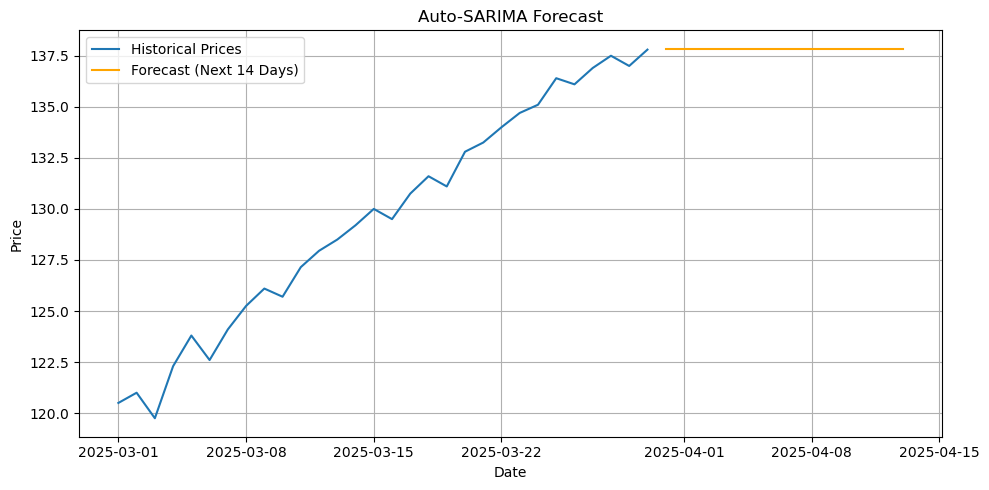


📈 Forecasted Prices for the Next 14 Days:
            Predicted_Price
Date                       
2025-03-31       137.839855
2025-04-01       137.839855
2025-04-02       137.839855
2025-04-03       137.839855
2025-04-04       137.839855
2025-04-05       137.839855
2025-04-06       137.839855
2025-04-07       137.839855
2025-04-08       137.839855
2025-04-09       137.839855
2025-04-10       137.839855
2025-04-11       137.839855
2025-04-12       137.839855
2025-04-13       137.839855


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

warnings.filterwarnings("ignore")

# Step 1: Load and preprocess the dataset
df = pd.read_csv("commodity_prices.csv")

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.dropna(subset=['Date', 'Price'], inplace=True)
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)
df = df[~df.index.duplicated(keep='first')]
df = df.asfreq('D')
df['Price'].interpolate(method='linear', inplace=True)

# Step 2: Auto-SARIMA parameter tuning
print("🔍 Finding optimal SARIMA parameters with auto_arima...")

stepwise_model = auto_arima(df['Price'],
                            seasonal=True,
                            m=7,  # weekly seasonality
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

print(f"\n✅ Best SARIMA parameters found: {stepwise_model.summary()}")

# Step 3: Fit SARIMA model using the best parameters
model = SARIMAX(df['Price'],
                order=stepwise_model.order,
                seasonal_order=stepwise_model.seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False)

model_fit = model.fit(disp=False)

# Step 4: Forecast the next 14 days
forecast_steps = 14
forecast = model_fit.forecast(steps=forecast_steps)
forecast_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=forecast_steps)
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Predicted_Price': forecast.values})
forecast_df.set_index('Date', inplace=True)

# Step 5: Plot
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Price'], label='Historical Prices')
plt.plot(forecast_df.index, forecast_df['Predicted_Price'], color='orange', label='Forecast (Next 14 Days)')
plt.title("Auto-SARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 6: Output forecast
print("\n📈 Forecasted Prices for the Next 14 Days:")
print(forecast_df)
